In [36]:
import string
import numbers
import math
import numpy as np
import pandas as pd
import cv2 as cv
import pprint
import scipy
import scipy.special
import scipy.spatial
import scipy.stats
import scipy.stats.qmc
import scipy.ndimage
import shapely
import shapely.geometry
import matplotlib
import matplotlib.patches
import matplotlib.patches as patches
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.collections as mc
from matplotlib.path import Path
from tabulate import tabulate
import networkx as nx

import torch

import utility as util
pp = pprint.PrettyPrinter(indent=4)

https://en.wikipedia.org/wiki/Inverse_transform_sampling

1. Generate a random number $u$ from the standard uniform distribution in the interval $[0,1]$, e.g. from $U\sim \mathrm {Unif} [0,1]$..
2. Find the inverse of the desired CDF, e.g.$F_{X}^{-1}(x)$.
3. Compute $X=F_{X}^{-1}(u)$. The computed random variable $X$ has distribution $F_X(x)$.



In [62]:
def sample_pdf(bins, weights, N_samples, det=False):
    # Get pdf
    weights = weights + 1e-5 # prevent nans
    pdf = weights / torch.sum(weights, -1, keepdim=True)
    cdf = torch.cumsum(pdf, -1)
    cdf = torch.cat([torch.zeros_like(cdf[...,:1]), cdf], -1)  # (batch, len(bins))

    # Take uniform samples
    if det:
        u = torch.linspace(0., 1., steps=N_samples)
        u = u.expand(list(cdf.shape[:-1]) + [N_samples])
    else:
        u = torch.rand(list(cdf.shape[:-1]) + [N_samples])

    # Invert CDF
    u = u.contiguous()
    inds = torch.searchsorted(cdf, u, right=True)
    below = torch.max(torch.zeros_like(inds-1), inds-1)
    above = torch.min((cdf.shape[-1]-1) * torch.ones_like(inds), inds)
    inds_g = torch.stack([below, above], -1)  # (batch, N_samples, 2)

    # cdf_g = tf.gather(cdf, inds_g, axis=-1, batch_dims=len(inds_g.shape)-2)
    # bins_g = tf.gather(bins, inds_g, axis=-1, batch_dims=len(inds_g.shape)-2)
    matched_shape = [inds_g.shape[0], inds_g.shape[1], cdf.shape[-1]]
    cdf_g = torch.gather(cdf.unsqueeze(1).expand(matched_shape), 2, inds_g)
    bins_g = torch.gather(bins.unsqueeze(1).expand(matched_shape), 2, inds_g)

    denom = (cdf_g[...,1]-cdf_g[...,0])
    denom = torch.where(denom<1e-5, torch.ones_like(denom), denom)
    t = (u-cdf_g[...,0])/denom
    samples = bins_g[...,0] + t * (bins_g[...,1]-bins_g[...,0])

    return samples


In [72]:
x = [-16., -15.88955032, -13.79719406, -11.50376164, -9.23401194, -6.7972302,
      -4.39565018, -2.20699269, -0.17509329, 2.34970027, 4.58082733,
       6.9216749, 9.1692103, 11.2758262, 13.74463244,  15.94867499]
y = [6.15973919e-19, 3.71976341e-15, 1.47494145e-11, 1.47107256e-08,
     7.42051892e-06, 9.54506879e-03, 1.64236818e-01, 6.69337539e-02,
     5.76356442e-02, 2.27615768e-02, 3.30201766e-03, 8.48201922e-02,
     5.30371579e-02, 1.07928951e-04, 2.47766170e-09]
x, y = torch.tensor(x)[None], torch.tensor(y)[None]
print(x.shape, y.shape)
z = sample_pdf(x, y, 100)
z = z.numpy()
z

torch.Size([1, 16]) torch.Size([1, 15])


array([[-4.1062965 , -3.5722585 , -2.4308639 , -2.3280547 , -2.524361  ,
        -0.28208256, -3.9999282 , -0.0374433 ,  0.8323649 ,  0.02670749,
        -2.696947  , -0.6091281 ,  0.8877988 , -4.0058637 , 10.554514  ,
        -1.3792093 , 10.2094145 ,  0.9614912 , -2.229178  , -3.6758702 ,
        -2.5580173 , -0.76146686, -0.3021915 , -3.0510654 , -5.853695  ,
         1.8049868 , -2.9250164 , -1.133204  ,  7.2331443 , -1.4335752 ,
        -3.641436  , -3.877519  , -4.303731  , -2.331845  ,  2.185885  ,
         7.633541  , 10.754959  , -0.19535446, 10.867686  , -3.4549546 ,
        -3.1872983 , -5.140786  ,  8.393505  ,  0.9599227 ,  9.087902  ,
         1.6943004 ,  8.964205  , 10.414984  ,  4.9219594 , -1.1805967 ,
        -4.075282  ,  8.376945  ,  2.911211  ,  8.939469  , 10.071992  ,
         8.855211  ,  4.5707355 , -0.4303    ,  7.296988  , -2.301447  ,
        -2.073128  , -2.274539  , -3.82269   , -3.7427108 , -3.0209665 ,
         0.5380372 , -2.6495256 , -2.7010279 , -3.8

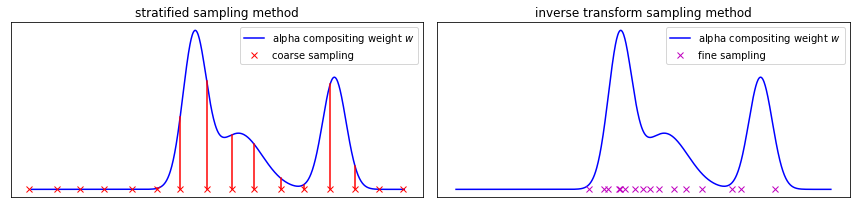

In [160]:
norm1 = scipy.stats.norm(loc=1.8, scale=2)
norm2 = scipy.stats.norm(loc=-2, scale=1)
norm3 = scipy.stats.norm(loc=10, scale=1)

fig = plt.figure(figsize=(12, 3))
ax = fig.add_subplot(121)

x = np.linspace(-16, 16, 1000)
y = 0.3*norm1.pdf(x) + 0.4*norm2.pdf(x) + 0.3*norm3.pdf(x)
ax.plot(x, y, "-b", label="alpha compositing weight $w$")

N = 16
_x = x
_y = y
x = np.linspace(-16, 16, N) + np.random.normal(loc=0, scale=0.1, size=N)
y = 0.3*norm1.pdf(x) + 0.4*norm2.pdf(x) + 0.3*norm3.pdf(x)
ax.plot(x, np.zeros(x.size), "rx", label="coarse sampling")
ax.set_title("stratified sampling method")

z = np.vstack((np.zeros(x.size)[None], y[None])).T
for _h, _z in zip(x, z):
    ax.plot([_h, _h], _z, "-r")

x = np.sort(np.insert(x, 0, -16.))
x, y = torch.tensor(x)[None], torch.tensor(y)[None]

# dists = np.cumsum(np.diff(x[0]))
# stepsizes = np.diff(x[0].numpy())
# transmittance = np.exp( np.cumsum(-stepsizes*dists) )
# dists = np.insert(dist, 0, 0.)
# stepsizes = torch.tensor(stepsizes)
# dists = torch.tensor(dist)
# alpha = 1. - torch.exp(-stepsizes*dists)
# transmittance = torch.tensor(transmittance)
# weights = transmittance * alpha
# weights = weights / torch.sum(weights)
# weights = weights[None]

z = sample_pdf(x, y, 16)
z = z.numpy()
ax = fig.add_subplot(122)

ax.plot(_x, _y, "-b", label="alpha compositing weight $w$")
ax.plot(z[0], np.zeros(z.size), "mx", label="fine sampling")
ax.set_title("inverse transform sampling method")

for ax in fig.axes:
    ax.set_xticks([]); ax.set_yticks([])
    ax.legend()
fig.tight_layout()

(-1.0, 2.0)

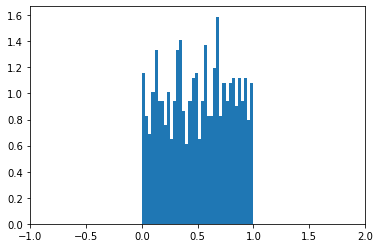

In [16]:
# uniform
x = np.random.uniform(0, 1, size=1000)
ax = plt.gca()
ax.hist(x, bins=36, density=True)
ax.set_xlim([-1, 2])

(-5.0, 5.0)

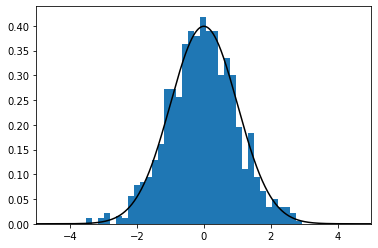

In [3]:
# normal
x = np.random.normal(loc=0.0, scale=1.0, size=1000)
ax = plt.gca()
ax.hist(x, bins=36, density=True)

x = np.linspace(-5, 5, 1000)
y = (1 / np.sqrt(2*np.pi))*np.exp(-x**2/2)
ax.plot(x, y, c="k")

ax.set_xlim([-5, 5])

(0.0, 50.0)

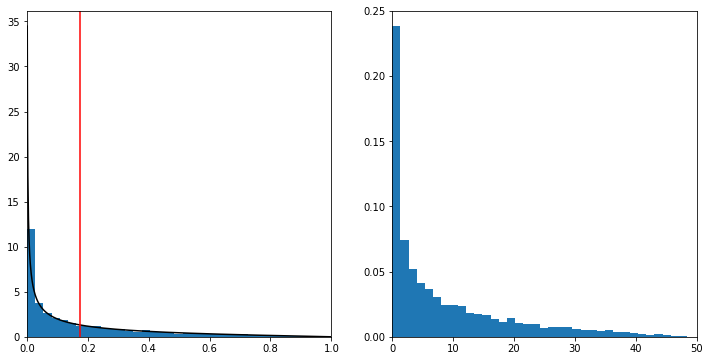

In [11]:
# beta distribution
# Based on
# https://www.desmos.com/calculator/pct1rbpkgv
# gamma function is G(z) = integrate{0, infty} t^{z-1} e^{-t} dt
# beta PDF is f(x;a,b) = G(a+b)/[G(a)G(b)] x^{a - 1}(1-x)^{b-1}

a = 0.4; b = 1.9
x = np.random.beta(a, b, size=10000)
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121)
ax.hist(x, bins=36, density=True)

_x = np.linspace(0.001, 0.999, 1000)
y = _x**(a - 1) * (1 - _x)**(b - 1) / scipy.special.beta(a, b)
ax.plot(_x, y, c="k")

plt.axvline(x=1/(1 + b/a), color="r", label="mean")

ax.set_xlim([0, 1])

ax = fig.add_subplot(122)
u = 0; v = 50
x = map_01_to_uv(u, v)(x)
ax = plt.gca()
ax.hist(x, bins=36, density=True)
ax.set_xlim([u, v])

(-20.0, 90.0)

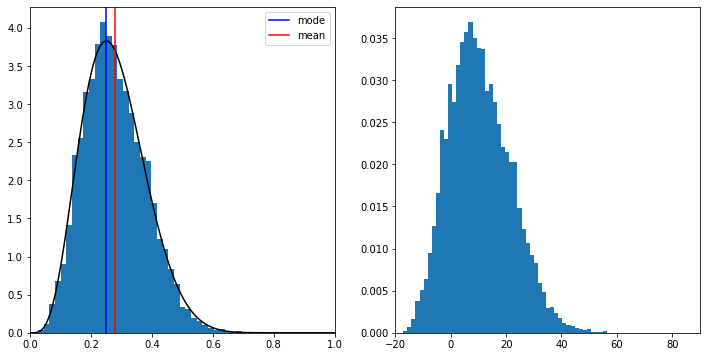

In [8]:
# beta with a mode
a = 5; b = 13
x = np.random.beta(a, b, size=10000)
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121)
ax.hist(x, bins=36, density=True)

_x = np.linspace(0.001, 0.999, 1000)
y = _x**(a - 1) * (1 - _x)**(b - 1) / scipy.special.beta(a, b)
ax.plot(_x, y, c="k")

plt.axvline(x=(a - 1)/(a + b - 2), color="b", label="mode")
plt.axvline(x=1/(1 + b/a), color="r", label="mean")

ax.set_xlim([0, 1])
ax.legend()

ax = fig.add_subplot(122)
u = -20; v = 90
x = util.map_01_to_uv(u, v)(x)
ax = plt.gca()
ax.hist(x, bins=50, density=True)
ax.set_xlim([u, v])

(-1.0, 90.0)

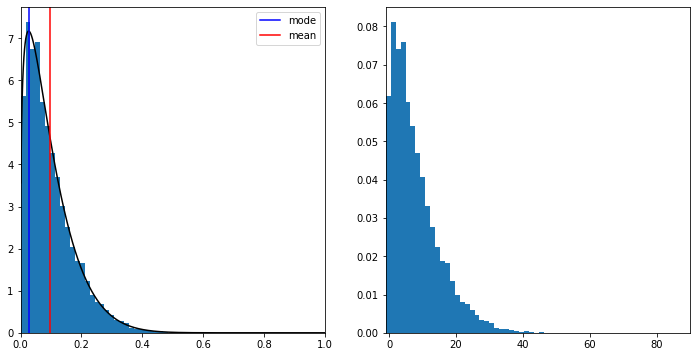

In [6]:
# beta with a mode
a = 1.3; b = 12
x = np.random.beta(a, b, size=10000)
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121)
ax.hist(x, bins=36, density=True)

_x = np.linspace(0.001, 0.999, 1000)
y = _x**(a - 1) * (1 - _x)**(b - 1) / scipy.special.beta(a, b)
ax.plot(_x, y, c="k")

plt.axvline(x=(a - 1)/(a + b - 2), color="b", label="mode")
plt.axvline(x=1/(1 + b/a), color="r", label="mean")

ax.set_xlim([0, 1])
ax.legend()

ax = fig.add_subplot(122)
u = -1; v = 90
x = util.map_01_to_uv(u, v)(x)
ax = plt.gca()
ax.hist(x, bins=36, density=True)
ax.set_xlim([u, v])

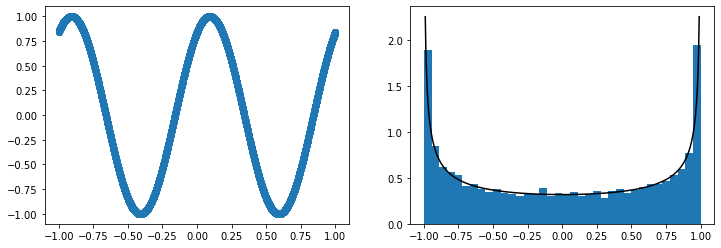

In [19]:
# Implicit Neural Representations with Periodic Activation Functions, SIREN
# https://arxiv.org/abs/2006.09661
# for a > \pi / 2 then and any b, if x ~ Unif[-1,1] and y = sin(ax+b) then y ~ Arcsine[-1,1]
N = 10000
x = np.random.uniform(low=-1, high=1, size=N)
a = 4 * np.pi / 2
b = 1
plt.figure(figsize=(12,4))
y = np.sin(a*x + b)

ax = plt.subplot(121)
ax.scatter(x, y)
ax = plt.subplot(122)
ax.hist(y, bins=36, density=True)

# Arcsine distribution
# https://en.wikipedia.org/wiki/Arcsine_distribution
x = np.linspace(-0.99, 0.99, 1000)
y = 1 /(np.pi * np.sqrt((x + 1)*(1 - x)))
ax.plot(x, y, c="k")

None